In [2]:
# from tkinter.messagebox import YES
import control as ctl
import matplotlib.pyplot as plt
import time

In [4]:
class PID():
    
    # --e(t)-->[PID Controller]--(u(t))-->[Plant]--(y(t))-->
    
    def __init__(self, kp: float, ki: float, kd: float, ts: float) -> None:
        
        self._Kp = kp
        self._Ki = ki
        self._Kd = kd
        self._Ts = ts   ## 采样间隔
        
    def process(self, et: list[list[float]], y: list[float], u: list[float], is_expert=False):
        
        ## et: error table
        
        output_u = self._Kp * et[-1][0] + self._Ki * et[-1][1] + self._Kd * et[-1][2]
        
        if is_expert:
            ## Expert PID Controller

            ## Rule 1. Open-loop
            if abs(et[-1][0]) > 0.8:
                output_u = 0.45
            elif (abs(et[-1][0])>0.40):        
                output_u = 0.40
            elif (abs(et[-1][0])>0.20): 
                output_u = 0.12
            elif (abs(et[-1][0])>0.01):
                output_u = 0.10
                    
            ## Rule 2. 
            if (et[-1][0] * et[-1][2] > 0) or (et[-1][2] == 0):
                if abs(et[-1][0]) >= 0.05:
                    output_u = u[-1] + 2*self._Kp*et[-1][0]
                else:
                    output_u = u[-1] + 0.4*self._Kp*et[-1][0]
            
            ## Rule 3.
            if (et[-1][0] * et[-1][2] < 0 and et[-1][2] * et[-2][2] > 0) or (et[-1][0] == 0):
                ...
                
            ## Rule 4.
            if et[-1][0] * et[-1][2] < 0 and et[-1][2] * et[-2][2] < 0:
                if abs(et[-1][0] >= 0.05):
                    output_u = u[-1] + 2*self._Kp*et[-1][0]
                else:
                    output_u = u[-1] + 0.6*self._Kp*et[-1][0]
                    
            ## Rule 5.
            if abs(et[-1][0] <= 0.001):
                output_u = 0.5*et[-1][0] + 0.010*et[-1][1]
            
            output_u = 10 if output_u >= 10 else output_u
            output_u = -10 if output_u <= -10 else output_u
        
        return output_u

In [5]:
# def test(kp, kd, ki, ts):

# if 1 == 1:
def test(kp, kd, ki, ts, flag):

    sys = ctl.tf([523500], [1, 87.35, 10470, 0])
    dsys = ctl.c2d(sys, ts, 'zoh')
    [num, den] = ctl.tfdata(dsys)
    
    pid = PID(kp, ki, kd, ts)
    
    y = [0,0,0]
    u = [0,0,0]
    
    times = [0,0,0]
    
    et = [[0,0,0], [0,0,0], [0,0,0]]
    
    st_point = 1.0
    
    for i in range(500):
        
        u_new = pid.process(et, y, u, flag)
        
        y_new = -den[0][0][1]*y[-1]-den[0][0][2]*y[-2]-den[0][0][3]*y[-3]\
                +num[0][0][0]*u[-1]+num[0][0][1]*u[-2]+num[0][0][2]*u[-3]
        
        error = st_point - y_new
        
        tmp_errs = [error, et[-1][1]+error*ts, (error-et[-1][0])/ts]
        
        et.append(tmp_errs)
        u.append(u_new)
        y.append(y_new)
        times.append(i*ts)
    
    # plt.figure(1)
    
    err = []
    
    for item in et:
        err.append(item[0])
        
    return times[3::],err[3::]
        
    # plt.title('PID Control')
    # plt.plot(times, y)
    # plt.xlabel('time(s)')
    # plt.ylabel('y')
    # plt.axhline(1, c = 'r', ls='--')
    # plt.grid()
    # plt.show()

In [7]:
times1, err1 = test(0.6, 0.03, 0.01, 0.001, True)
times2, err2 = test(0.6, 0.03, 0.01, 0.001, False)

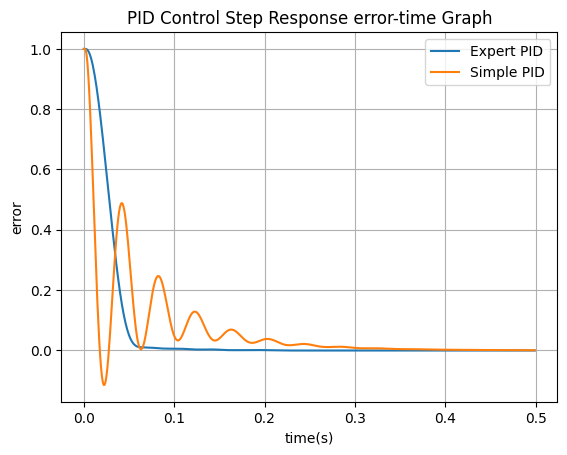

In [12]:
plt.title('PID Control Step Response error-time Graph')
plt.plot(times1, err1, label='Expert PID')
plt.plot(times2, err2, label='Simple PID')
plt.xlabel('time(s)')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.show()

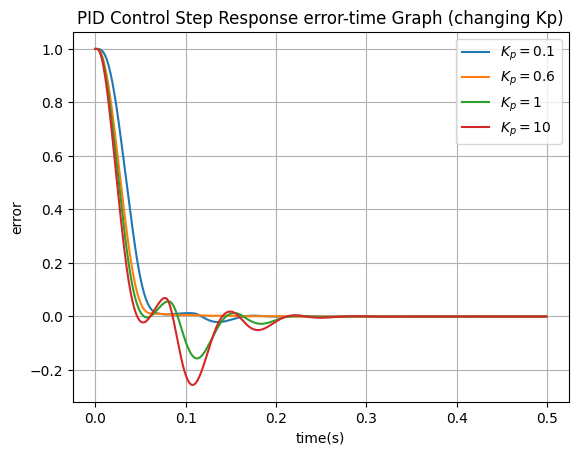

In [40]:
times1, err1 = test(0.1, 0.03, 0.01, 0.001, True)
times2, err2 = test(0.6, 0.03, 0.01, 0.001, True)
times3, err3 = test(0.8, 0.03, 0.01, 0.001, True)
times4, err4 = test(1.0, 0.03, 0.01, 0.001, True)

plt.title('PID Control Step Response error-time Graph (changing Kp)')
plt.plot(times1, err1, label=r'$K_p = 0.1$')
plt.plot(times2, err2, label=r'$K_p = 0.6$')
plt.plot(times3, err3, label=r'$K_p = 1$')
plt.plot(times4, err4, label=r'$K_p = 10$')
plt.xlabel('time(s)')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.show()

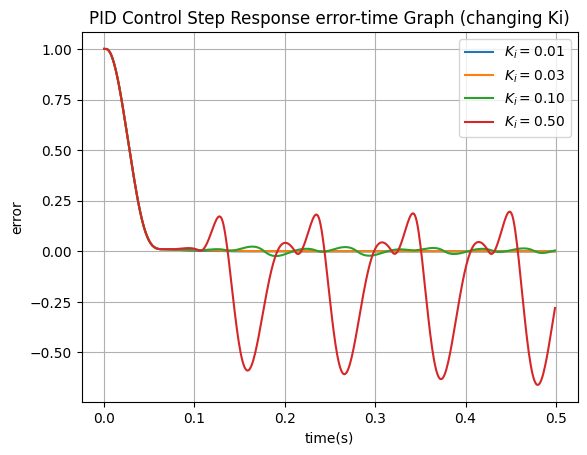

In [41]:
times1, err1 = test(0.6, 0.01, 0.01, 0.001, True)
times2, err2 = test(0.6, 0.03, 0.01, 0.001, True)
times3, err3 = test(0.6, 0.10, 0.01, 0.001, True)
times4, err4 = test(0.6, 0.50, 0.01, 0.001, True)

plt.title('PID Control Step Response error-time Graph (changing Ki)')
plt.plot(times1, err1, label=r'$K_i = 0.01$')
plt.plot(times2, err2, label=r'$K_i = 0.03$')
plt.plot(times3, err3, label=r'$K_i = 0.10$')
plt.plot(times4, err4, label=r'$K_i = 0.50$')
plt.xlabel('time(s)')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.show()

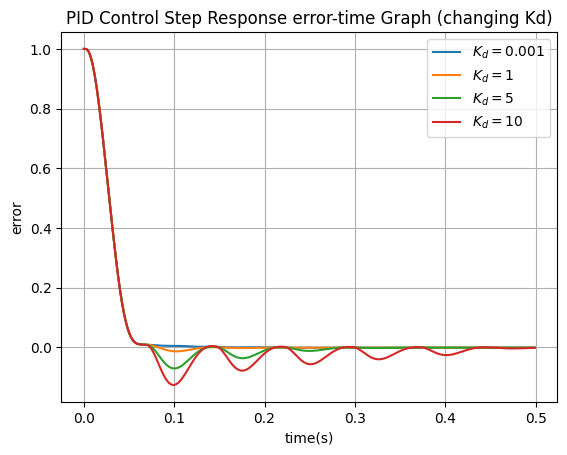

In [42]:
times1, err1 = test(0.6, 0.03, 0.01, 0.001, True)
times2, err2 = test(0.6, 0.03, 1, 0.001, True)
times3, err3 = test(0.6, 0.03, 5, 0.001, True)
times4, err4 = test(0.6, 0.03, 10, 0.001, True)

plt.title('PID Control Step Response error-time Graph (changing Kd)')
plt.plot(times1, err1, label=r'$K_d = 0.001$')
plt.plot(times2, err2, label=r'$K_d = 1$')
plt.plot(times3, err3, label=r'$K_d = 5$')
plt.plot(times4, err4, label=r'$K_d = 10$')
plt.xlabel('time(s)')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.show()

In [28]:
times2

[0.0,
 0.005,
 0.01,
 0.015,
 0.02,
 0.025,
 0.03,
 0.035,
 0.04,
 0.045,
 0.05,
 0.055,
 0.06,
 0.065,
 0.07,
 0.075,
 0.08,
 0.085,
 0.09,
 0.095,
 0.1,
 0.105,
 0.11,
 0.115,
 0.12,
 0.125,
 0.13,
 0.135,
 0.14,
 0.145,
 0.15,
 0.155,
 0.16,
 0.165,
 0.17,
 0.17500000000000002,
 0.18,
 0.185,
 0.19,
 0.195,
 0.2,
 0.20500000000000002,
 0.21,
 0.215,
 0.22,
 0.225,
 0.23,
 0.23500000000000001,
 0.24,
 0.245,
 0.25,
 0.255,
 0.26,
 0.265,
 0.27,
 0.275,
 0.28,
 0.28500000000000003,
 0.29,
 0.295,
 0.3,
 0.305,
 0.31,
 0.315,
 0.32,
 0.325,
 0.33,
 0.335,
 0.34,
 0.34500000000000003,
 0.35000000000000003,
 0.355,
 0.36,
 0.365,
 0.37,
 0.375,
 0.38,
 0.385,
 0.39,
 0.395,
 0.4,
 0.405,
 0.41000000000000003,
 0.41500000000000004,
 0.42,
 0.425,
 0.43,
 0.435,
 0.44,
 0.445,
 0.45,
 0.455,
 0.46,
 0.465,
 0.47000000000000003,
 0.47500000000000003,
 0.48,
 0.485,
 0.49,
 0.495,
 0.5,
 0.505,
 0.51,
 0.515,
 0.52,
 0.525,
 0.53,
 0.535,
 0.54,
 0.545,
 0.55,
 0.555,
 0.56,
 0.5650000000000

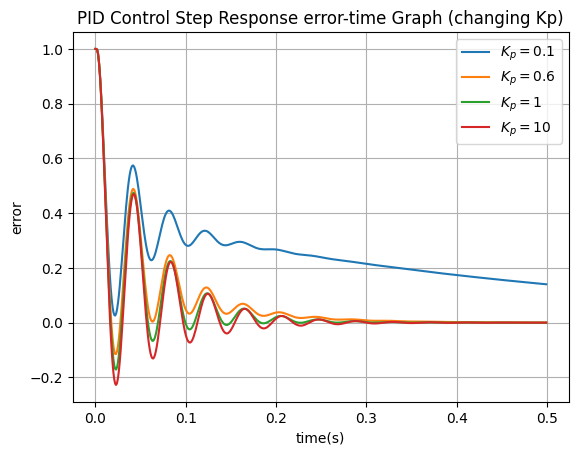

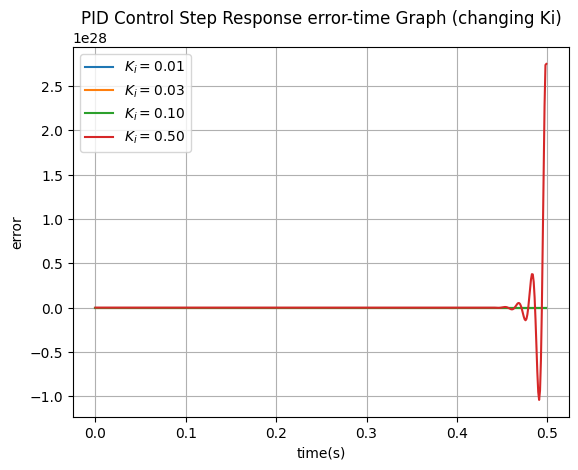

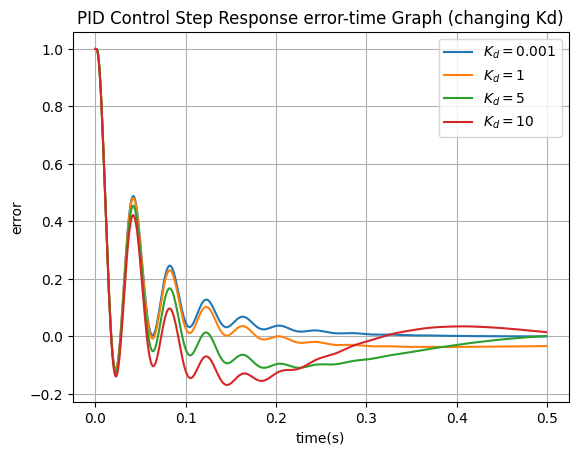

In [6]:
times1, err1 = test(0.1, 0.03, 0.01, 0.001, False)
times2, err2 = test(0.6, 0.03, 0.01, 0.001, False)
times3, err3 = test(0.8, 0.03, 0.01, 0.001, False)
times4, err4 = test(1.0, 0.03, 0.01, 0.001, False)

plt.figure(1)
plt.title('PID Control Step Response error-time Graph (changing Kp)')
plt.plot(times1, err1, label=r'$K_p = 0.1$')
plt.plot(times2, err2, label=r'$K_p = 0.6$')
plt.plot(times3, err3, label=r'$K_p = 1$')
plt.plot(times4, err4, label=r'$K_p = 10$')
plt.xlabel('time(s)')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.show()

times1, err1 = test(0.6, 0.01, 0.01, 0.001, False)
times2, err2 = test(0.6, 0.03, 0.01, 0.001, False)
times3, err3 = test(0.6, 0.10, 0.01, 0.001, False)
times4, err4 = test(0.6, 0.50, 0.01, 0.001, False)

plt.figure(2)
plt.title('PID Control Step Response error-time Graph (changing Ki)')
plt.plot(times1, err1, label=r'$K_i = 0.01$')
plt.plot(times2, err2, label=r'$K_i = 0.03$')
plt.plot(times3, err3, label=r'$K_i = 0.10$')
plt.plot(times4, err4, label=r'$K_i = 0.50$')
plt.xlabel('time(s)')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.show()

times1, err1 = test(0.6, 0.03, 0.01, 0.001, False)
times2, err2 = test(0.6, 0.03, 1, 0.001,    False)
times3, err3 = test(0.6, 0.03, 5, 0.001,    False)
times4, err4 = test(0.6, 0.03, 10, 0.001,   False)

plt.figure(3)
plt.title('PID Control Step Response error-time Graph (changing Kd)')
plt.plot(times1, err1, label=r'$K_d = 0.001$')
plt.plot(times2, err2, label=r'$K_d = 1$')
plt.plot(times3, err3, label=r'$K_d = 5$')
plt.plot(times4, err4, label=r'$K_d = 10$')
plt.xlabel('time(s)')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.show()